# Generate data for the interactive application

Generates tree in a Newick format and ID mappings to link colors and branches to PMtiles.

In [ ]:
import json

import numpy as np
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, to_tree

Metadata

In [ ]:
v = 'v8'
lower_cut = 200  # the lowest level shown in tree - matched to labels in pmtiles
higher_cut = 750  # level at which colors are assigned

Read linkage matrix.

In [65]:
linkage_matrix = np.load(f'/data/uscuni-ulce/processed_data/clusters/complete_linkage_10_{v}.npy')

Visualise

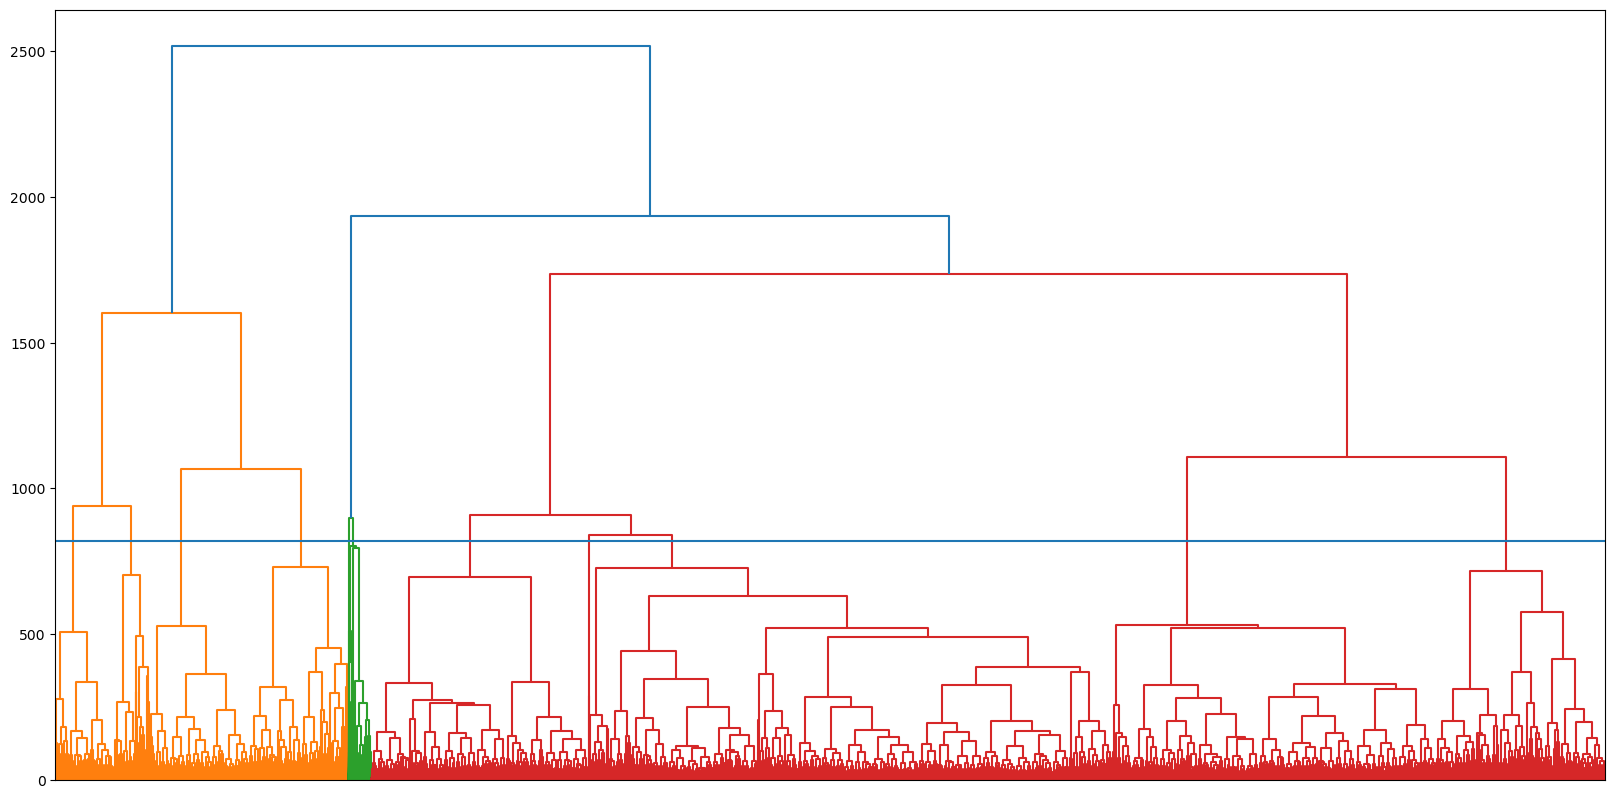

In [ ]:
fig,ax = plt.subplots(figsize=(20,10))
d = dendrogram(linkage_matrix ,ax=ax, no_labels=True)
ax.axhline(higher_cut)
ax.axhline(lower_cut)

Define the function that converts the linkage matrix to Newick.

In [68]:
def linkage_to_newick(Z, labels, cutoff=0):
    """
    """
    level_ids = []
    tree = to_tree(Z, False) #scipy.sp_hierarchy.to_tree
    def build_newick(node, newick, parentdist, leaf_names, level_ids):
        if node.is_leaf() or node.dist < cutoff: # This is for SciPy not for ete or skbio so `is_leaf` utility function does not apply
            level_ids.append(node.id)
            return f"{node.id}:{(parentdist - node.dist)/2}{newick}", level_ids
        else:
            if len(newick) > 0:
                newick = f"){node.id}:{(parentdist - node.dist)/2}{newick}"
            else:
                newick = ");"
            newick, level_ids = build_newick(node.get_left(), newick, node.dist, leaf_names, level_ids)
            newick, level_ids = build_newick(node.get_right(), f",{newick}", node.dist, leaf_names, level_ids)
            newick = f"({newick}"
            return newick, level_ids
    return build_newick(tree, "", tree.dist, labels, level_ids)

Generate Newick.

In [ ]:
newick, level_ids = linkage_to_newick(linkage_matrix, d['leaves'], cutoff=lower_cut)

# post-process to encode lowest level with cluster ID
newick_to_cluster = {str(value): str(i + 1) for i, value in enumerate(level_ids)}
for k, v in newick_to_cluster.items():
    newick = newick.replace(k, v)

# save to a file
with open("tree.txt", "w") as file:
    file.write(newick)

Generate mapping from low cut to high cut.

In [ ]:
low = fcluster(linkage_matrix, lower_cut, criterion='distance')
high = fcluster(linkage_matrix, higher_cut, criterion='distance')

mapping = dict(zip(low, high))
mapping = {str(k): str(v) for k, v in mapping.items()}

with open("mapping.json", "w") as json_file:
    json.dump(mapping, json_file)

Generate IDs for the higher cut.

In [ ]:
_, ids_for_tree = linkage_to_newick(linkage_matrix, d['leaves'], cutoff=higher_cut)

with open("ids_for_tree.json", "w") as json_file:
    json.dump(ids_for_tree, json_file)

The final step is to copy files `tree.txt`, `mapping.json` and `ids_for_tree.json` to the repository with the application.